# HW 2: Clustering and Topic Models [100 points]

Name: Sayo Sanu

Andrew ID: esanu

Collaborators (if none, say "none"; do *not* leave this blank): 
https://scikit-learn.org/stable/user_guide.html
https://stackoverflow.com/
https://www.youtube.com/watch?v=3mHy4OSyRf0

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [282]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [283]:
########################################################################
######################### Write your code here #########################
import glob

all_files = glob.glob('./data/enron/*.txt')  #add all files to a list
processed_docs = []
for each_file in all_files:
    processed_doc = makeWordList(each_file)
    processed_docs.append(processed_doc)
########################################################################

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [284]:
########################################################################
######################### Write your code here #########################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words='english', max_df=0.8)
X = vectorizer.fit_transform(processed_docs)

print('There are', X.shape[1], 'unique words in the dictionary')
########################################################################

There are 1680 unique words in the dictionary


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [285]:
########################################################################
######################### Write your code here #########################
from sklearn.mixture import GaussianMixture
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

gmm = GaussianMixture(n_components=3, n_init=200, random_state=0)
doc_clusters = gmm.fit_predict(X.toarray())

for cluster in range(doc_clusters.max() + 1):
    print('Cluster', cluster, 'has', np.count_nonzero([doc_clusters == cluster]), 'documents')  #using mask, print non-zero count

########################################################################

Cluster 0 has 485 documents
Cluster 1 has 365 documents
Cluster 2 has 4321 documents


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [286]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

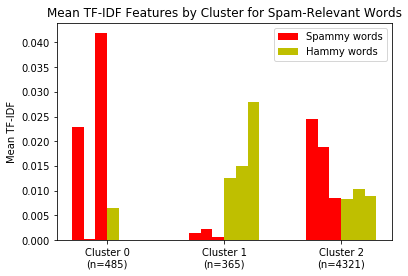

In [287]:
########################################################################
######################### Write your code here #########################
spam_indices = []
for word in ['click', 'www', 'offer']:
    index = vectorizer.vocabulary_[word]
    spam_indices.append(index)
    
ham_indices = []
for word in ['meeting', 'attached', 'review']:
    index = vectorizer.vocabulary_[word]
    ham_indices.append(index)

num_clusters = 3
plot_spam_words_by_cluster(doc_clusters, num_clusters, spam_indices, ham_indices)
########################################################################

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

Based on the plot generated, when there are 3 clusters, cluster 0 appears to be correlated with spammy emails. Cluster 1 and 2 appear to have a split between hammy and spammy emails, with cluster 1 having a higher frequency of hammy words, and cluster 2 having a higher frequency of spam. 

Changing the number of clusters to 2 makes the result appear worse. Though the frequency of spammy words in cluster 0 is higher, the clusters are not as well defined. Using the selected spammy and hammy words, we can find both types of emails in both clusters. 

Changing the number of clusters to 5 has a better result. Clusters 0 - 3 have a very high frequency  of spammy words, indicating that those clusters are related to spammy emails. Cluster 4, on the other hand, has a high frequency of hammy words. 

In [ ]:
########################################################################
######################### Write your code here #########################
num_cluster2 = 2
gmm2 = GaussianMixture(n_components=num_cluster2, n_init=200, random_state=0)
doc_clusters2 = gmm2.fit_predict(X.toarray())

num_cluster3 = 5
gmm3 = GaussianMixture(n_components=num_cluster3, n_init=200, random_state=0)
doc_clusters3 = gmm3.fit_predict(X.toarray())
########################################################################

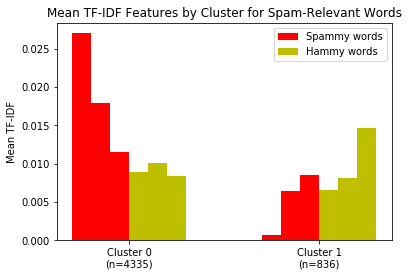

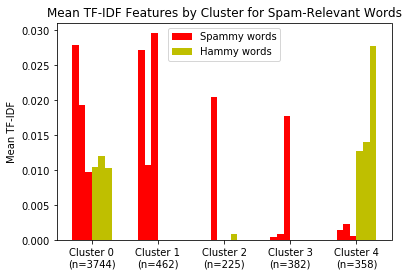

In [292]:
plot_spam_words_by_cluster(doc_clusters2, num_cluster2, spam_indices, ham_indices)
plot_spam_words_by_cluster(doc_clusters3, num_cluster3, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [2]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [3]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [4]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [5]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

C:\Users\HEINZ\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [6]:
########################################################################
######################### Write your code here #########################
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
X_transformed = transformer.fit_transform(X)
########################################################################

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [7]:
%%time
########################################################################
######################### Write your code here #########################
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, n_jobs=-1, max_iter=10)
model = lda.fit(X_transformed)
########################################################################

Wall time: 3min 55s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [8]:
########################################################################
######################### Write your code here #########################
import numpy as np

num_top_purposes = 10

purpose_distributions = np.array([purpose_pseudocounts / np.sum(purpose_pseudocounts) 
                                  for purpose_pseudocounts in model.components_])

print('Displaying the top %d app purposes per topic:' % num_top_purposes)
print()

for topic_idx in range(model.components_.shape[0]):
    print('Topic ', topic_idx, end = ':\n')
    sort_indices = np.argsort(purpose_distributions[topic_idx])[::-1]
    for rank in range(num_top_purposes):
        purpose_idx = sort_indices[rank]
        if rank == 9:
            print(permission_columns[purpose_idx], end = '. ')
        else: 
            print(permission_columns[purpose_idx], end = ', ')
    print('\n')
########################################################################

Displaying the top 10 app purposes per topic:

Topic  0:
Your personal information : read contact data (D), Services that cost you money : send SMS messages (D), Your accounts : discover known accounts (S), Your messages : receive SMS (D), Phone calls : read phone state and identity (D), Your personal information : write contact data (D), Your messages : read SMS or MMS (D), Network communication : full Internet access (D), Phone calls : intercept outgoing calls (D), Services that cost you money : directly call phone numbers (D). 

Topic  1:
Hardware controls : take pictures and videos (D), System tools : automatically start at boot (S), Network communication : receive data from Internet (S), Storage : modify/delete USB storage contents modify/delete SD card contents (D), Network communication : view network state (S), Hardware controls : control vibrator (S), Network communication : full Internet access (D), Phone calls : read phone state and identity (D), System tools : prevent devic

Some related permissions are common amongst the topics, e.g. access to internet, network state. This indicates that these apps are internet enabled. Though these permissions are common amongst the topics, some of the topics appear to be meaniful from the app permissions they request. 

Topic 2: Appears to be a eevent social because of request to read and modify calendar events.

Topic 3: Appears to be an enterprise application because of request to modify google settings.

Topic 4: Appears to be related to communication apps because of the app permisions to write contact data, intercept phone calls, send or read SMS, network and internet access and so on

Topic 7: Appears to be network app because of request to discover known accounts

Topic 8: Appears to be a communication app because of request to call phone numbers, and use services that cost money (voice call/SMS perhaps)

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [9]:
########################################################################
######################### Write your code here #########################
#to filter out app data with reviews less than 100k get app index to remove from matrix
index_list = []
for index, each_rating in enumerate(app_ratings):
    if each_rating > 100000:
        index_list.append(index)
        
temp_df = pd.DataFrame(X)        
filtered_df = temp_df.iloc[index_list, :]
X_filtered = filtered_df.as_matrix()
del temp_df

X_f_transformed = transformer.fit_transform(X_filtered)
filtered_app_names =  [app_names[index] for index in index_list]  

topic_dist_over_apps = lda.transform(X_f_transformed)
top_n_apps = 3

for each_topic in range(topic_dist_over_apps.shape[1]):
    print('Topic ', each_topic, end = ':\n')
    sorted_apps = np.argsort(topic_dist_over_apps[:, each_topic])[::-1]
    for rank in range(top_n_apps):
        app_index = sorted_apps[rank]
        print(filtered_app_names[app_index], end='\n')
    print()
########################################################################

Topic  0:
Zynga Poker
Horoscope
chompSMS

Topic  1:
Seesmic (Facebook, Twitter)
Tiny Flashlight + LED
eBuddy Messenger

Topic  2:
Wallpapers HD
Robo Defense FREE
Strip Poker

Topic  3:
Skype
WhatsApp Messenger
Tango Voice & Video Calls

Topic  4:
Bible
Dolphin Browser™ HD
Dolphin Browser??? HD

Topic  5:
Racing Moto
Fruit Slice
SpeechSynthesis Data Installer

Topic  6:
Toss It
Dictionary.com
Air Control Lite

Topic  7:
Real BlackJack
Vaulty Free Hides Pictures
Live Holdem Poker Pro

Topic  8:
Adobe Reader
Mouse Trap
Drag Racing

Topic  9:
Angry Birds Seasons
Yoo Ninja! Free
Adobe Flash Player 11



C:\Users\HEINZ\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

Wall time: 19.3 s


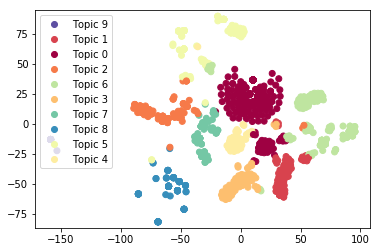

In [62]:
%%time
########################################################################
######################### Write your code here #########################
from sklearn.manifold import TSNE

tsne = TSNE(angle=0.99, init='pca', learning_rate=200)

doc_topic_model = lda.transform(X_transformed)

sample_data = np.random.permutation(doc_topic_model.shape[0])[:1100]
tsne_model = tsne.fit_transform(doc_topic_model[sample_data])

color = [point.argmax() for point in doc_topic_model[sample_data]] #create color list
legend = ['Topic {}'.format(topic.argmax()) for topic in doc_topic_model[sample_data]]  #create legend list
zip_legend_color = set(zip(color, legend)) #zip list and remove duplicates

tsne_plot = plt.scatter(tsne_model[:, 0], tsne_model[:, 1], cmap='Spectral',c=color) 
handles = [plt.plot([], color=tsne_plot.get_cmap()(tsne_plot.norm(color)), ls = '', marker ='o')[0] for color, legend in zip_legend_color]
legend = [legend for color, legend in zip_legend_color]
plt.legend(handles, legend)
plt.axis('equal')
########################################################################

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://goo.gl/forms/qi1acwKwxSfNJfjt1